In [1]:
from source import data_wrangle
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
advanced = data_wrangle.read_all_advanced('./data/advanced')
pergame  = data_wrangle.read_all_pergame('./data/per_game')
seasonal = data_wrangle.clean_and_join_seasonal_dataframe(advanced, pergame)
demographic = data_wrangle.read_demographic_data('./data/player_data.csv')

In [3]:
seasonal.head(3)

,Player,Pos,Age,Tm,G,MP_total,PER,TS%,3PAr,FTr,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G
0,A.C. Green,PF,33,TOT,83,2492,12.4,0.523,0.041,0.407,...,0.650,2.7,5.2,7.9,0.8,0.8,0.2,0.9,1.7,7.2
441,A.C. Green,PF,34,DAL,82,2649,12.8,0.496,0.007,0.303,...,0.716,2.7,5.5,8.1,1.5,1.0,0.3,0.8,1.9,7.3
880,A.C. Green,PF,35,DAL,50,924,12.5,0.441,0.031,0.203,...,0.577,1.6,2.9,4.6,0.5,0.6,0.2,0.4,1.4,4.9


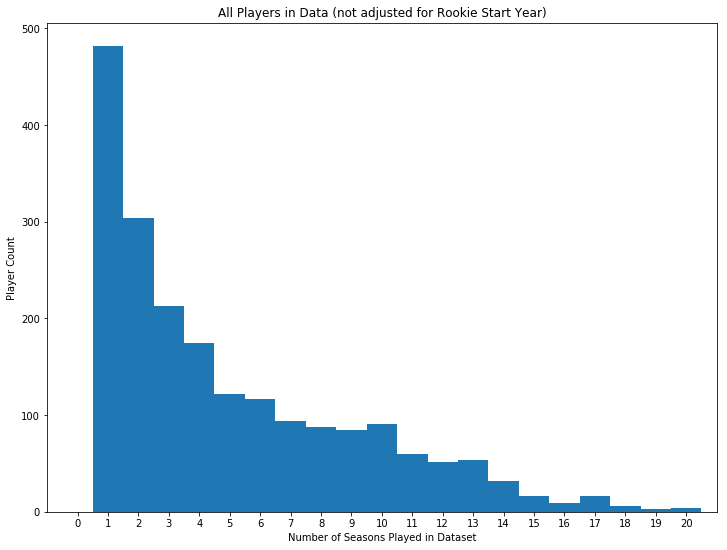

In [4]:
data = seasonal.groupby('Player').count()['Pos']
bins = np.arange(22) - 0.5
plt.figure(figsize=(12,9))
plt.hist(data, bins)
plt.xticks(range(21))
plt.xlim([-1,21])
plt.xlabel('Number of Seasons Played in Dataset')
plt.ylabel('Player Count')
plt.title('All Players in Data (not adjusted for Rookie Start Year)')


plt.show()

For how many players do we have more than 4 years of data?

In [5]:
atleastfouryears = data[data > 4]
atleastfouryears.shape[0]

848

Text(0.5, 1.0, 'Greater than 4yr Player Counts (not adjusted for Rookie Start Year)')

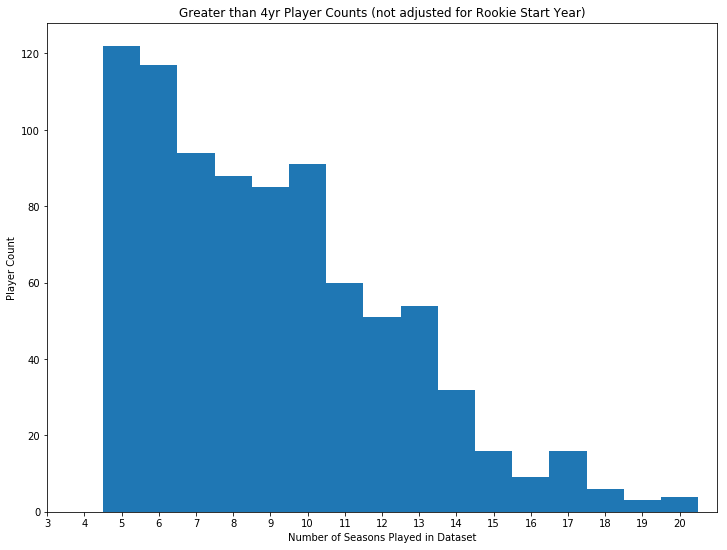

In [6]:
bins = np.arange(22) - 0.5
plt.figure(figsize=(12,9))
plt.hist(atleastfouryears, bins)
plt.xticks(range(21))
plt.xlim([3,21])
plt.xlabel('Number of Seasons Played in Dataset')
plt.ylabel('Player Count')
plt.title('Greater than 4yr Player Counts (not adjusted for Rookie Start Year)')

Plot Average minutes year 4 x-axis, years in league (5-9 in y)

In [7]:
seasonal.head()[['Player', 'Season']]

,Player,Season
0,A.C. Green,1997
441,A.C. Green,1998
880,A.C. Green,1999
1320,A.C. Green,2000
1759,A.C. Green,2001


In [8]:
demographic[demographic['name']=='LeBron James']

,name,year_start,year_end,position,height,weight,birth_date,college
1948,LeBron James,2004,2018,F-G,6-8,250.0,"December 30, 1984",NaN


In [9]:
seasonal[seasonal['Player']=='LeBron James'][['Age','Season']]

,Age,Season
3314,19,2004
3776,20,2005
4240,21,2006
4691,22,2007
5152,23,2008
5595,24,2009
6045,25,2010
6502,26,2011
6985,27,2012
7453,28,2013


In [10]:
def add_years_in_league(df_seasonal, df_demographic):
    '''
    Adds the number of years the player has been in the league to the seasonal dataframe.
    Calculates the delta from the demo database
    Inputs: df_seasonal -- the output of the clean_and_join_seasonal_dataframe function
            df_demographic -- the output of the read_demographic_data function
            
    Returns: df_seasonal_plus_years_in_league
    
    '''
    #Was going to loop through and get unique names, realized that could be obviated by left-join
    #names_in_demo = set(df_demographic['name'].unique())
    #names_in_seaonal = set(df_seasonal['Player'].unique())
    
    #Left merge the two dataframes on player name, which exclude the old-timers that aren't in 1997+
    joinedup = pd.merge(df_seasonal, df_demographic.loc[:,['name', 'year_start']], how='left', left_on=['Player'], right_on = ['name'])
    
    #The players that aren't in the demo table are 1st year G-league-level guys
    joinedup.loc[joinedup['year_start'].isnull(),'year_start']= 2018
    #Cast the year_start column to int because Pandas is goofy
    joinedup['year_start'] = joinedup['year_start'].astype(int)
    
    #Get the season number in the table, which is just the number of years the player has been in the league
    #Note that the player's rookie year starts at 1
    joinedup['Seasons_number'] = joinedup['Season'] - joinedup['year_start'] + 1
    
    #Dropped the name and year_start--don't think it makes sense to duplicate the name and year_start repeats
    joinedup.drop(['name','year_start'],axis=1,inplace=True)
    
    return joinedup 

In [11]:
joinedup = pd.merge(seasonal, demographic, how='left', left_on=['Player'], right_on = ['name'])

In [12]:
joinedup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10116 entries, 0 to 10115
Data columns (total 60 columns):
Player        10116 non-null object
Pos           10116 non-null object
Age           10116 non-null int64
Tm            10116 non-null object
G             10116 non-null int64
MP_total      10116 non-null int64
PER           10116 non-null float64
TS%           10116 non-null float64
3PAr          10116 non-null float64
FTr           10116 non-null float64
ORB%          10116 non-null float64
DRB%          10116 non-null float64
TRB%          10116 non-null float64
AST%          10116 non-null float64
STL%          10116 non-null float64
BLK%          10116 non-null float64
TOV%          10116 non-null float64
USG%          10116 non-null float64
OWS           10116 non-null float64
DWS           10116 non-null float64
WS            10116 non-null float64
WSp48         10116 non-null float64
OBPM          10116 non-null float64
DBPM          10116 non-null float64
BPM         

Per my analysis yesterday, these null players appear to be G-League/1st year guys

In [13]:
joinedup[joinedup['year_start'].isnull()] 

,Player,Pos,Age,Tm,G,MP_total,PER,TS%,3PAr,FTr,...,PF,PS/G,name,year_start,year_end,position,height,weight,birth_date,college
40,Aaron Jackson,PG,31,HOU,1,35,2.4,0.405,0.444,0.222,...,4.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
377,Andre Ingram,SG,32,LAL,2,64,16.3,0.655,0.529,0.176,...,1.5,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
479,Andrew White,SF,24,ATL,15,209,5.8,0.461,0.671,0.055,...,0.8,4.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
841,Ben Moore,PF,22,IND,2,9,-2.3,0.000,0.000,0.000,...,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1650,Chris Boucher,PF,25,GSW,1,1,-28.5,0.000,1.000,0.000,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2115,Damion Lee,SG,25,ATL,15,404,12.0,0.489,0.395,0.191,...,1.7,10.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2438,Davon Reed,SG,22,PHO,21,242,4.8,0.388,0.500,0.158,...,0.8,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2752,Devin Robinson,SF,22,WAS,1,13,10.5,0.333,0.000,0.000,...,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3145,Edmond Sumner,PG,22,IND,1,2,39.8,1.000,0.000,0.000,...,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3355,Erik McCree,SF,24,UTA,4,8,-8.9,0.000,0.500,0.000,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
joinedup.loc[joinedup['year_start'].isnull(),'year_start']= 2018

In [15]:
joinedup['year_start'] = joinedup['year_start'].astype(int)

In [16]:
joinedup[joinedup['Player']=='Ben Moore']

,Player,Pos,Age,Tm,G,MP_total,PER,TS%,3PAr,FTr,...,PF,PS/G,name,year_start,year_end,position,height,weight,birth_date,college
841,Ben Moore,PF,22,IND,2,9,-2.3,0.0,0.0,0.0,...,2.0,0.0,NaN,2018,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
joinedup['Season_number'] = joinedup['Season'] - joinedup['year_start'] + 1

In [18]:
joinedup[joinedup['Player']=='Dirk Nowitzki'][['Player','Season_number', 'Season']]

,Player,Season_number,Season
2812,Dirk Nowitzki,1,1999
2813,Dirk Nowitzki,2,2000
2814,Dirk Nowitzki,3,2001
2815,Dirk Nowitzki,4,2002
2816,Dirk Nowitzki,5,2003
2817,Dirk Nowitzki,6,2004
2818,Dirk Nowitzki,7,2005
2819,Dirk Nowitzki,8,2006
2820,Dirk Nowitzki,9,2007
2821,Dirk Nowitzki,10,2008


In [19]:
joinedup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10116 entries, 0 to 10115
Data columns (total 61 columns):
Player           10116 non-null object
Pos              10116 non-null object
Age              10116 non-null int64
Tm               10116 non-null object
G                10116 non-null int64
MP_total         10116 non-null int64
PER              10116 non-null float64
TS%              10116 non-null float64
3PAr             10116 non-null float64
FTr              10116 non-null float64
ORB%             10116 non-null float64
DRB%             10116 non-null float64
TRB%             10116 non-null float64
AST%             10116 non-null float64
STL%             10116 non-null float64
BLK%             10116 non-null float64
TOV%             10116 non-null float64
USG%             10116 non-null float64
OWS              10116 non-null float64
DWS              10116 non-null float64
WS               10116 non-null float64
WSp48            10116 non-null float64
OBPM             101

In [20]:
joinedup.head(1).T

,0
Player,A.C. Green
Pos,PF
Age,33
Tm,TOT
G,83
MP_total,2492
PER,12.4
TS%,0.523
3PAr,0.041
FTr,0.407


In [21]:
joined = data_wrangle.add_years_in_league(seasonal, demographic)

In [22]:
joined

,Player,Pos,Age,Tm,G,MP_total,PER,TS%,3PAr,FTr,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,Seasons_number
0,A.C. Green,PF,33,TOT,83,2492,12.4,0.523,0.041,0.407,...,2.7,5.2,7.9,0.8,0.8,0.2,0.9,1.7,7.2,12
1,A.C. Green,PF,34,DAL,82,2649,12.8,0.496,0.007,0.303,...,2.7,5.5,8.1,1.5,1.0,0.3,0.8,1.9,7.3,13
2,A.C. Green,PF,35,DAL,50,924,12.5,0.441,0.031,0.203,...,1.6,2.9,4.6,0.5,0.6,0.2,0.4,1.4,4.9,14
3,A.C. Green,PF,36,LAL,82,1929,11.2,0.482,0.010,0.245,...,2.0,4.0,5.9,1.0,0.6,0.2,0.6,1.5,5.0,15
4,A.C. Green,PF,37,MIA,82,1411,11.2,0.492,0.019,0.343,...,1.3,2.5,3.8,0.5,0.4,0.1,0.5,1.5,4.5,16
5,A.J. Bramlett,C,23,CLE,8,61,-0.4,0.190,0.000,0.000,...,1.5,1.3,2.8,0.0,0.1,0.0,0.4,1.6,1.0,1
6,A.J. Guyton,PG,22,CHI,33,630,10.3,0.495,0.359,0.094,...,0.3,0.8,1.1,1.9,0.3,0.2,0.7,1.1,6.0,1
7,A.J. Guyton,PG,23,CHI,45,607,11.8,0.477,0.504,0.111,...,0.3,0.7,1.0,1.8,0.2,0.2,0.8,0.5,5.4,2
8,A.J. Guyton,PG,24,GSW,2,9,-9.0,0.000,0.250,0.000,...,0.0,0.0,0.0,1.0,0.5,0.0,0.5,0.0,0.0,3
9,A.J. Hammons,C,24,DAL,22,163,8.4,0.472,0.238,0.476,...,0.4,1.3,1.6,0.2,0.0,0.6,0.5,1.0,2.2,1


Text(0.5, 1.0, 'Number of Seasons Played in Data (Adjusted for Rookied Year)')

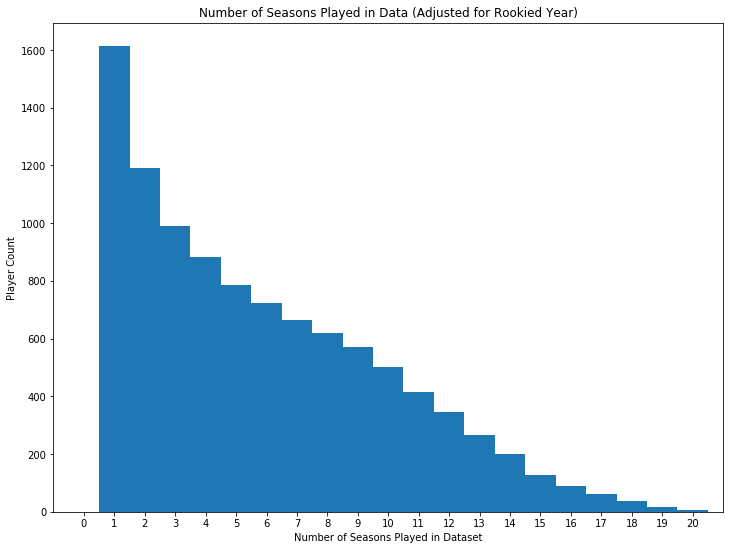

In [23]:
data = joined['Seasons_number']
bins = np.arange(22) - 0.5
plt.figure(figsize=(12,9))
plt.hist(data, bins)
plt.xticks(range(21))
plt.xlim([-1,21])
plt.xlabel('Number of Seasons Played in Dataset')
plt.ylabel('Player Count')
plt.title('Number of Seasons Played in Data (Adjusted for Rookied Year)')

Um, who is the zero?

In [25]:
min(data)

1

Name collisions in the database.  Too many generics.

In [28]:
joined[joined['Seasons_number']<1]

,Player,Pos,Age,Tm,G,MP_total,PER,TS%,3PAr,FTr,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,Seasons_number


In [29]:
joined[joined['Seasons_number']<1]['Player'].unique()

array([], dtype=object)

In [30]:
repeats = ['Charles Jones', 'Charles Smith', 'Chris Johnson', 'Chris Wright',
       'Dee Brown', 'Gary Payton', 'Glen Rice', 'Glenn Robinson',
       'Marcus Williams', 'Mike James', 'Patrick Ewing',
       'Reggie Williams', 'Tim Hardaway']

In [31]:
joined[(joined['Player']=='Patrick Ewing') & (joined['Season'] > 2002)]

,Player,Pos,Age,Tm,G,MP_total,PER,TS%,3PAr,FTr,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,Seasons_number


In [32]:
joined[(joined['Player']=='Patrick Ewing')]['Season']

Series([], Name: Season, dtype: int64)

In [33]:
joined.loc[(joined['Player']=='Patrick Ewing') & (joined['Season'] < 2003),'Player']= "Patrick Ewing (i)"

In [34]:
joined[(joined['Player']=='Patrick Ewing (i)')]['Season']

7523    1997
7524    1998
7525    1999
7526    2000
7527    2001
7528    2002
Name: Season, dtype: int64

In [35]:
joined[joined['Player']=='Chris Johnson']

,Player,Pos,Age,Tm,G,MP_total,PER,TS%,3PAr,FTr,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,Seasons_number


In [36]:
joined[joined['Player']=='Chris Wright']

,Player,Pos,Age,Tm,G,MP_total,PER,TS%,3PAr,FTr,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,Seasons_number


In [37]:
joined[joined['Player']=='Marcus Williams']

,Player,Pos,Age,Tm,G,MP_total,PER,TS%,3PAr,FTr,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,Seasons_number
6469,Marcus Williams,PG,21,NJN,79,1315,11.5,0.474,0.310,0.162,...,0.4,1.7,2.1,3.3,0.4,0.0,1.8,1.2,6.8,1
6470,Marcus Williams,PG,22,NJN,53,854,11.0,0.499,0.485,0.160,...,0.3,1.6,1.9,2.6,0.5,0.1,1.4,1.0,5.9,2
6471,Marcus Williams,PG,23,GSW,9,54,3.7,0.305,0.353,0.353,...,0.0,0.4,0.4,1.4,0.1,0.1,0.4,0.7,1.3,3
6472,Marcus Williams,PG,24,MEM,62,872,10.6,0.456,0.299,0.203,...,0.2,1.3,1.5,2.6,0.5,0.0,1.2,0.7,4.3,4


In [38]:
seasonal[seasonal['Player']=='Marcus Williams'][['Season','Tm']]

,Season,Tm
4715,2007,NJN
5177,2008,NJN
5620,2009,GSW
6069,2010,MEM


In [39]:
pergame[pergame['Player']=='Marcus Williams']

,Rk,Player,GS,MP_pergame,FG,FGA,FG%,3P,3PA,3P%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,Season
503,446,Marcus Williams,2,16.6,2.6,6.7,0.395,0.6,2.1,0.282,...,0.4,1.7,2.1,3.3,0.4,0.0,1.8,1.2,6.8,2007
571,436,Marcus Williams,7,16.1,2.1,5.5,0.379,1.0,2.7,0.380,...,0.3,1.6,1.9,2.6,0.5,0.1,1.4,1.0,5.9,2008
564,430,Marcus Williams,0,6.0,0.4,1.9,0.235,0.2,0.7,0.333,...,0.0,0.4,0.4,1.4,0.1,0.1,0.4,0.7,1.3,2009
564,429,Marcus Williams,1,14.1,1.7,4.4,0.384,0.4,1.3,0.296,...,0.2,1.3,1.5,2.6,0.5,0.0,1.2,0.7,4.3,2010


In [40]:
joined[joined['Player']=='Charles Smith']

,Player,Pos,Age,Tm,G,MP_total,PER,TS%,3PAr,FTr,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PS/G,Seasons_number


In [41]:
advanced[advanced['Player']=='Charles Smith'][['Season','Pos']]

,Season,Pos
475,1997,PF
357,1998,SG
421,1999,SG
422,2002,SG
397,2003,SG
451,2006,SG


In [42]:
advanced[advanced['Player']=='Charles Smith'][['Season','Pos']]

,Season,Pos
475,1997,PF
357,1998,SG
421,1999,SG
422,2002,SG
397,2003,SG
451,2006,SG
